# Информация о датасете
1. Данные об использовании смартфонов. Датасет был взят с сайта www.kagle.com по [ссылке](https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset). Датасет был сгенерирован искуственно.
2. В датасете представлены следующие атрибуты:
 - User ID - идентификатор пользователя
 - Operating System - Android или iOS
 - App Usage Time (min/day) - использование приложений (мин в день)
 - Screen On Time (hours/day) - время включенного экрана смартфона (часов в день)
 - Battery Drain (mAh/day) - разряд батареи в сутки
 - Number of Apps Installed - количество установленных приложений
 - Data Usage (MB/day) - использование сети в мб в день
 - Age - возраст
 - Gender - Пол
 - User Behavior Class - классификация поведения пользователя

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('user_behavior_dataset.csv')
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


# Обработка датасета

## Преобразуем датасет
- Удалим Device Model, Operating System, Gender, User Behavior Class
- Переименуем App Usage Time (min/day) в Usage Time, Screen On Time (hours/day) в Screen Time, Battery Drain (mAh/day) в Battery Drain, Data Usage (MB/day) в Data Usage
- Добавим атрибут Screen Time Battery Drain = Battery Drain / Screen Time
- Преобразуем App Usage Time в часы/день

In [6]:
def minutes_to_hours(minutes):
    return minutes / 60

df.drop(columns=['User ID', 'Device Model', 'Operating System', 'Gender', 'User Behavior Class'], inplace=True)
df.rename(columns={'App Usage Time (min/day)': 'Usage Time', 'Screen On Time (hours/day)': 'Screen Time', 'Battery Drain (mAh/day)': 'Battery Drain', 'Data Usage (MB/day)': 'Data Usage'}, inplace=True)
df['Usage Time'] = df['Usage Time'].apply(minutes_to_hours)
df['Screen Time B. Dr.'] = df['Battery Drain'] // df['Screen Time']

## Почистим датасет
- Удалим выбросы
- Удалим дубликаты
- Заполним пропуски

In [9]:
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers
def delete_outliers(data, column): 
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data
def fill_gaps(data, column):
    return data

In [11]:
duplicates = df.duplicated().sum()
if duplicates:
    df = df.drop_duplicates()
    print(f'Удалено {duplicates} дубликатов.')
else:
    print(f'В наборе нет дубликатов')
sum_gaps = 0
sum_outliers = 0
for column in df.columns:
    gaps = df[column].isna().sum()
    sum_gaps += gaps
    if gaps:
        df = fill_gaps(df, column)
    outliers = len(detect_outliers(df[column]))
    sum_outliers += outliers
    if outliers:
        df = delete_outliers(df, column)
if sum_gaps:
    print(f'Заполнено {sum_gaps} пропущенных значений.')
else:
    print(f'В наборе нет пропущенных значений.')
if sum_outliers:
    print(f'Удалено {sum_outliers} выбросов.')
else:
    print(f'В наборе нет выбросов.')

В наборе нет дубликатов
В наборе нет пропущенных значений.
Удалено 29 выбросов.


## Выведем матрицу графиков рассеивания

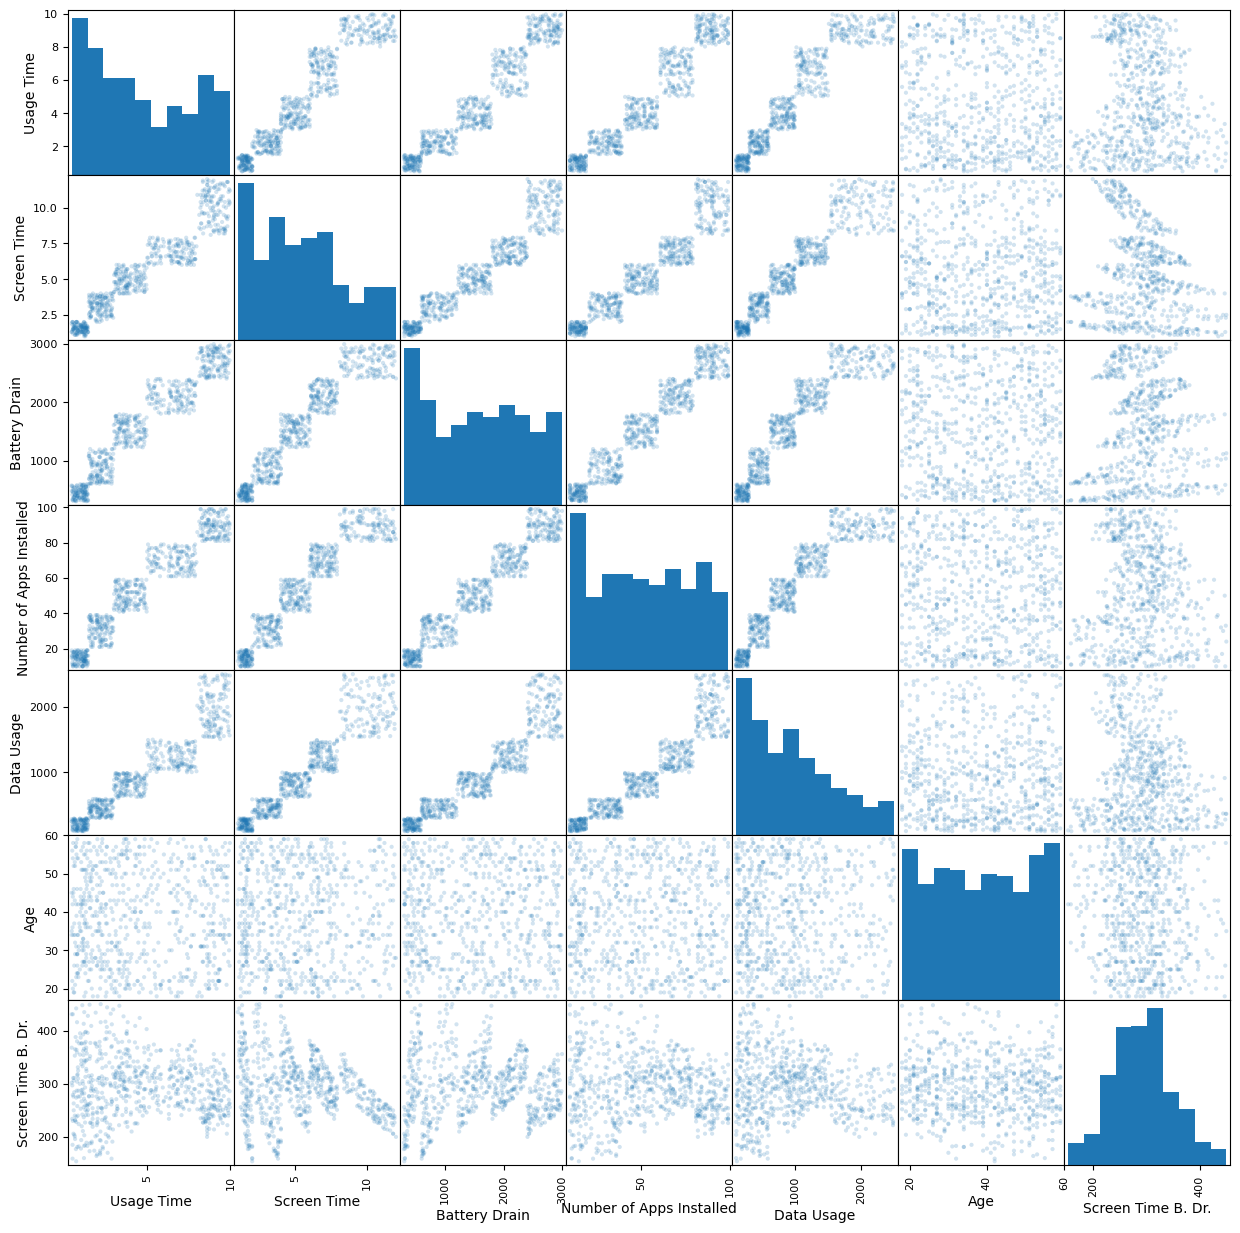

In [14]:
scatter_matrix(df, alpha = 0.2, figsize = (15, 15), diagonal = 'hist')
plt.show()


__На матрице четко видны 5 кластеров, для интереса проведём кластеризацию по новому атрибуту__

# Кластеризация

In [17]:
x_label = 'Data Usage'
y_label = 'Screen Time B. Dr.'
clusterisation_data = df[[x_label, y_label]]

## Найдем "локоть" по графику инерции

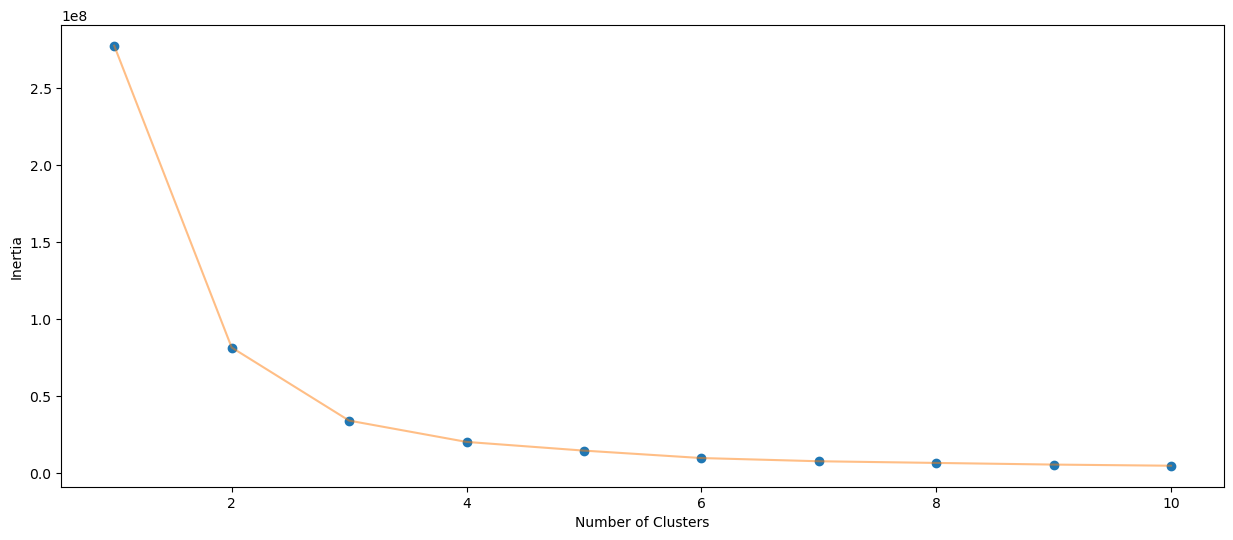

In [19]:
inertia = []
for n in range(1 , 11):
    algorithm = KMeans(n_clusters = n)
    algorithm.fit(clusterisation_data)
    inertia.append(algorithm.inertia_)
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

__По графику видим, что "локоть" (рекомендуемое значение кластеров) равно 3.__

## Применим KMeans кластеризацию для N = 3, добавим аттрибут kmeans для определения кластера объекта

In [22]:
algorithm = KMeans(n_clusters = 3)
algorithm.fit(clusterisation_data)
df['kmeans'] = algorithm.labels_
centroids = algorithm.cluster_centers_
df.head()

,Usage Time,Screen Time,Battery Drain,Number of Apps Installed,Data Usage,Age,Screen Time B. Dr.,kmeans
0,6.550000,6.4,1872,67,1122,40,292.0,0
1,4.466667,4.7,1331,42,944,47,283.0,0
2,2.566667,4.0,761,32,322,42,190.0,1
3,3.983333,4.8,1676,56,871,20,349.0,0
4,3.116667,4.3,1367,58,988,31,317.0,0


## Построим диаграмму рассеивания для N = 3 кластеров

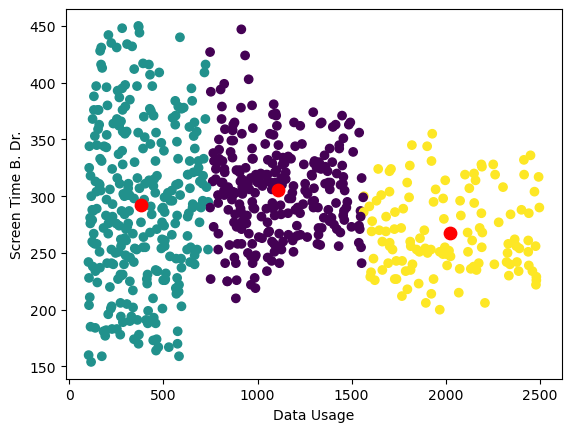

In [24]:
plt.scatter(x=df[x_label], y=df[y_label], c=df['kmeans'])
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red')
plt.xlabel(x_label) , plt.ylabel(y_label)
plt.show()

## Применим KMeans кластеризацию для N = 5, добавим аттрибут kmeans для определения кластера объекта

In [28]:
algorithm = KMeans(n_clusters = 5)
algorithm.fit(clusterisation_data)
df['kmeans'] = algorithm.labels_
centroids = algorithm.cluster_centers_
df.head()

,Usage Time,Screen Time,Battery Drain,Number of Apps Installed,Data Usage,Age,Screen Time B. Dr.,kmeans
0,6.550000,6.4,1872,67,1122,40,292.0,3
1,4.466667,4.7,1331,42,944,47,283.0,3
2,2.566667,4.0,761,32,322,42,190.0,4
3,3.983333,4.8,1676,56,871,20,349.0,3
4,3.116667,4.3,1367,58,988,31,317.0,3


## Построим диаграмму рассеивания для N = 5 кластеров

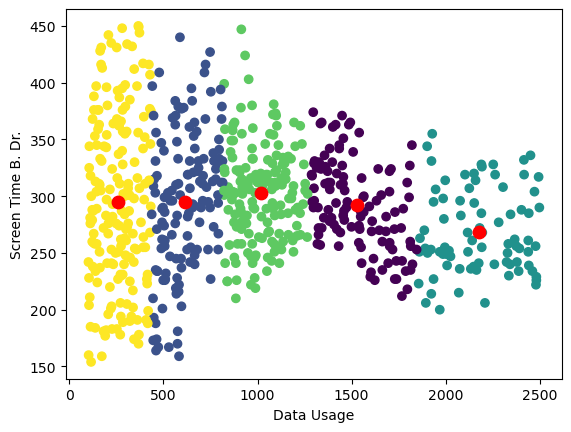

In [34]:
plt.scatter(x=df[x_label], y=df[y_label], c=df['kmeans'])
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red')
plt.xlabel(x_label) , plt.ylabel(y_label)
plt.show()

__В целом, видим, что N = 3 и N = 5 кластеров для взятых атрибутов разделяют значение на достаточно четко видимые группы__